Not working check it

In [23]:
import torch, torch.utils.data
from torch import nn
import torchvision, torchvision.datasets
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List

import sys


sys.path.append('./datasets/')

from datasets.dataloader import get_LEAF_dataloader

from torch.profiler import profile, record_function, ProfilerActivity
import time
from sklearn.metrics import f1_score   
import numpy as np
    
import random

In [24]:
print(torch.__version__)




2.0.0


In [25]:
def get_femnist_shakespeare_dataset(**args):
    if args['dataset'] == 'femnist' or args['dataset'] == 'shakespeare':
        trainloader, testloader = get_LEAF_dataloader(dataset=args['dataset'],
                                                      client_id=args['rank'])
    else:
        raise ValueError("Invalid dataset:", args['dataset'])
    return trainloader, testloader

In [26]:

train_loaders = []
test_loaders = []
num_nodes = 5
num_class = 62
epoch_total = 50
pickle_name = "femnist-p2p-epoch-"+str(epoch_total)

for i in range(num_nodes):
    args = {'dataset': 'femnist', 'rank': i}
    trainloader, testloader = get_femnist_shakespeare_dataset(**args)
    train_loaders.append(trainloader)
    test_loaders.append(testloader)


In [27]:
device = torch.device('cuda')
torch.cuda.get_device_name(device)

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [28]:

transform = transforms.Compose([
    transforms.ToTensor(),
])
target_transform = lambda x: torch.nn.functional.one_hot(torch.tensor(x),num_class).float()

In [29]:
print(len(train_loaders))
print(len(test_loaders))
print(test_loaders)
print(len(test_loaders[0].dataset))

5
5
[<torch.utils.data.dataloader.DataLoader object at 0x7f73245aa920>, <torch.utils.data.dataloader.DataLoader object at 0x7f7324497eb0>, <torch.utils.data.dataloader.DataLoader object at 0x7f7324497940>, <torch.utils.data.dataloader.DataLoader object at 0x7f7324496c20>, <torch.utils.data.dataloader.DataLoader object at 0x7f7324496d40>]
35


In [30]:

x_i_j = {}
s_i = {}

ypred = []
ylabels = []

In [31]:
class FederatedNode:
    def __init__(self, train_dataloader, test_dataloader, node_id) -> None:
        self.dataset_size = len(train_dataloader.dataset)
        channels_sum, channels_squared_sum, num_batches = 0, 0, 0
        for data, _ in train_dataloader:
            # Mean over batch, height and width, but not over the channels
            channels_sum += torch.mean(data, dim=[0])
            channels_squared_sum += torch.mean(data**2, dim=[0])
            num_batches += 1
    
        self.mean = channels_sum / num_batches
        self.test_loss = 0.0
        self.test_accuracy = 0.0
        self.train_accuracy = 0.0
        self.train_loss = 0.0
        self.f1_score = 0.0


        # std = sqrt(E[X^2] - (E[X])^2)
        self.std = (channels_squared_sum / num_batches - self.mean ** 2) ** 0.5
        print("Dataset size ", self.dataset_size)
        print("Mean size ", self.mean.shape)
        print("Standard deviation size ", self.std.shape)
        
        
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784,56),
            nn.ReLU(),
            nn.Linear(56, 62)
        ).to(device)

        '''
        only_digits=False
        self.network = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(9216, 128),
        nn.Dropout(0.5),
        nn.Linear(128, 10 if only_digits else 62),
        nn.ReLU()
        ).to(device)
        '''
        self.optimizer = torch.optim.Adam(self.network.parameters())
        self.criterion = nn.CrossEntropyLoss()
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.node_id = node_id
    
    def train_epoch(self):
        losses = []
        correct = 0
        total = 0
        train_accuracy = []
        for idx, (data_x, data_y) in enumerate(self.train_dataloader):
            #print("data_x", data_x.shape)
            #print("data_y", data_y.shape)
            #plt.imshow(data_x[1][0])
            output = self.network(data_x.to(device))
            self.optimizer.zero_grad()
            #print(output.shape)
            #print(data_y)
            #data_y = target_transform(data_y)
            
            #loss = nn.functional.mse_loss(output, data_y.to(device))
            loss = self.criterion(output, data_y.to(device))
            losses.append(loss.item())
            loss.backward()
            self.optimizer.step()

            _, predicted = torch.max(output.data, 1)
            data_y = data_y.to(predicted.device)
            true_labels = data_y
            #true_labels = torch.argmax(data_y, dim=1).to(predicted.device)
            total += data_y.size(0)
            correct += (predicted == true_labels).sum().item()
            train_accuracy.append(correct / total)
            ypred.append(data_y)
            ylabels.append(true_labels)
        self.train_accuracy = train_accuracy[-1]
        self.train_loss = sum(losses)/len(losses)
        return self.train_accuracy, self.train_loss
    
    def testing(self):
        correct = 0
        total = 0
        # test_running_loss = 0.0
        predictions = []
        labels = []
        test_accuracy = []
        test_running_losses = []
        for idx, (data_x, data_y) in enumerate(self.test_dataloader):
            output = self.network(data_x.to(device))
            
            _, predicted = torch.max(output.data, 1)
            data_y = data_y.to(predicted.device)
            true_labels = data_y
            #true_labels = torch.argmax(data_y, dim=1).to(predicted.device)
            total += data_y.size(0)
            correct += (predicted == true_labels).sum().item()
            
            loss = self.criterion(output, data_y)
            predictions.append(predicted.cpu())
            #labels.append(data_y.cpu())
            labels.append(true_labels.cpu())
            test_running_losses.append(loss.item())
            #print('Epoch %d test loss: %.3f' % (idx + 1, test_running_losses[-1]))
            #print(test_running_losses)
            #test_running_loss += loss.item()
            #test_loss.append(test_running_loss / len(self.test_dataloader))
            test_accuracy.append(correct / total)
        
        #print(predictions)
        predictions = np.concatenate(predictions)
        labels = np.concatenate(labels)
        self.f1_score= f1_score(labels, predictions, average="weighted")
        self.test_accuracy = test_accuracy[-1]
        #print(self.test_accuracy)
        self.test_loss =  sum(test_running_losses)/len(test_running_losses)
        #print("test loss ",self.test_loss)
       
    
    def share_x_ij(self):
        x = self.network.state_dict()
        r = torch.randint(1, 5, [num_nodes])
        s_r = torch.sum(r)
        j=self.node_id
        for i in range(num_nodes):
            x_i_j[(i,j)]={}
            for key in x.keys():
                x_i_j[(i,j)][key]=x[key]*r[i]/s_r
                
        
    
    def share_s_i(self):
        i = self.node_id
        s_i[i] = {}
        for key in x_i_j[(0,0)].keys():
            s_i[i][key] = sum([x_i_j[(i,j)][key] for j in range(num_nodes)])

    def share_x_ij_neighbours(self, neighbour_nodes):
        j=self.node_id
        num_neighbour_nodes = len(neighbour_nodes)
        x = self.network.state_dict()
        r = torch.randint(1, 5, [num_neighbour_nodes])
        s_r = torch.sum(r)
        
        for i, n in enumerate(neighbour_nodes):
            x_i_j[(n,j)]={}
            for key in x.keys():
                x_i_j[(n,j)][key]=x[key]*r[i]/s_r

    def share_s_i_neighbours(self, neighbour_nodes):
        i = self.node_id
        s_i[i] = {}
        
        for key in x_i_j[list(x_i_j.keys())[0]].keys():
            s_i[i][key] = sum([x_i_j[(i,j)][key] for j in neighbour_nodes])


    def share_FedavgP2P(self, nodes):
        dataset_size_all = [n.dataset_size for n in nodes]
        i = self.node_id
        C = 0.5
        A = num_nodes - 1
        m = C*A
        #n_k = self.dataset_size

        # Random clients
        S_t = random.sample([ j for j in range(num_nodes) if j!=i], int(m)) 
        S_t.append(self.node_id)
        #print("Clients ",S_t)
        #S_t = random.sample(list(range(num_nodes)) , int(m))
        #print("n_k ",n_k)
        #print("m neighbors", m)
        #print("S_t", S_t)
        w_c = self.network.state_dict()
        n_c = self.dataset_size
        n_t = n_c
        for s in S_t:
            n_t += dataset_size_all[s]
        
        for j in S_t: 
            nodes[j].share_x_ij_neighbours(S_t)
        for j in S_t: 
            nodes[j].share_s_i_neighbours(S_t)
                
        for key in nodes[0].network.state_dict():
            for j in S_t: 
                n_k = dataset_size_all[j]
                #states = nodes[j].network.state_dict()
                averaged_state = {}
            
                for key in s_i[list(s_i.keys())[0]].keys():
                    param_value = 0
                    for i in s_i:
                        param_value += s_i[i][key]
                    
                    averaged_state[key] = param_value/len(S_t)
                #print(averaged_state)
                #contributed_state = n_k/n_t*averaged_state[key]
                #w_c[key] = w_c[key] + contributed_state
                w_c[key] = averaged_state[key]
                
        self.network.load_state_dict(w_c)


In [32]:
#for i, loader_data in enumerate(zip(*loader)):
#    train_loaders, test_loaders = loader_data

nodes = []
for i in range(num_nodes):
    nodes.append(FederatedNode(train_loaders[i], test_loaders[i], i)) 

#nodes = [FederatedNode(l, i) for i,l in enumerate())]

Dataset size  309
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  136
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  213
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  249
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  215
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])


In [33]:
losses = {}
train_accuracies = {}
test_accuracies = {}
test_losses = {}
f1_scores = {}
#with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
#    with record_function("model_training"):

start_time = time.time()
dataset_size_all = {}
epochs ={i:0 for i in range(num_nodes)}

for i in tqdm(range(epoch_total*num_nodes)):
    cands = [i for i in epochs if epochs[i]<epoch_total]
    node_c = nodes[cands[torch.randint(len(cands), (1,)).item()]]
    del cands
    train_acc, loss = node_c.train_epoch()
    epochs[node_c.node_id] += 1
    losses[(node_c.node_id, epochs[node_c.node_id])]=loss
    print(f"{node_c.node_id}:{epochs[node_c.node_id]}={loss}")
    train_accuracies[(node_c.node_id, epochs[node_c.node_id])]=train_acc

    x_i_j = {}
    s_i = {}
    for node in nodes:
        node.share_x_ij()
    
    for node in nodes:
        node.share_s_i()
    

    node_c.share_FedavgP2P(nodes)
    


    # for i, node in enumerate(nodes):
        #print()
        #print("Node ", i)
        
    node_c.testing()
    #test_losses.append(node.test_loss)
    #print("Node Test Accuracy", node.test_accuracy)
    #print("Node Test loss", node.test_loss)
    #print("Node F1_Score ", node.f1_score)
    test_accuracies[(node_c.node_id, epochs[node_c.node_id])]=node_c.test_accuracy
    test_losses[(node_c.node_id, epochs[node_c.node_id])]=node_c.test_loss
    f1_scores[(node_c.node_id, epochs[node_c.node_id])]=node_c.f1_score
    

            
    # test_accuracies.append(epoch_test_accuracies)
    # test_losses.append(epoch_test_losses)
    # f1_scores.append(epoch_f1_scores)


    
    #av_state = {}
    #print(s_i[0])
    #for key in s_i[0].keys():
    #    av_state[key]=torch.mean(torch.tensor([s_i[i][key] for i in s_i]), dim=[0])
    # averaged_state = {}
    # for key in s_i[0].keys():
    #     param_value = 0
    #     for i in s_i:
    #         param_value += s_i[i][key]
        
    #     averaged_state[key] = param_value/num_nodes

    # for node in nodes:
    #     node.network.load_state_dict(averaged_state)

    
    
    
    # states = [i.network.state_dict() for i in nodes]
    # av_state = {}
    # for key in states[0]:
    #     av_state[key] = sum([s[key] for s in states])/num_nodes
    # for node in nodes:
    #     node.network.load_state_dict(av_state)

time_FL_SMPC = time.time() - start_time

print("Time taken by FL with SMPC", time_FL_SMPC)
    


  2%|▏         | 6/250 [00:00<00:04, 59.03it/s]

4:1=4.144367456436157
4:2=3.9847549200057983
1:1=4.278110027313232
1:2=4.085063457489014
3:1=4.131402254104614
0:1=4.170898914337158
1:3=3.9947848320007324
2:1=4.193741321563721


  5%|▍         | 12/250 [00:00<00:04, 55.30it/s]

0:2=4.087114016215007
2:2=4.040165543556213
2:3=4.002399206161499
1:4=3.9424448013305664


  7%|▋         | 18/250 [00:00<00:04, 55.14it/s]

2:4=3.97058641910553
2:5=3.9466540813446045
3:2=3.903476595878601
3:3=3.8218436241149902
4:3=3.9460673332214355
1:5=3.906871199607849
4:4=3.949325919151306
2:6=3.929901599884033
4:5=3.973165988922119
0:3=4.064029852549235
2:7=3.961233615875244


 12%|█▏        | 30/250 [00:00<00:04, 52.93it/s]

0:4=4.270691871643066
0:5=4.62914244333903
2:8=4.197186231613159
1:6=3.9277831315994263
4:6=4.075879454612732
3:4=3.7722182273864746
0:6=4.527706305185954
2:9=4.171975612640381
3:5=4.312154054641724
3:6=5.9154791831970215
3:7=6.8316144943237305
0:7=5.678115526835124


 17%|█▋        | 42/250 [00:00<00:03, 54.70it/s]

0:8=6.51564359664917
3:8=6.431580543518066
0:9=8.545275847117106
3:9=7.32830548286438
2:10=5.8683905601501465
2:11=10.147045135498047
1:7=4.526081800460815
4:7=4.516364336013794
2:12=12.13960599899292
1:8=14.931541919708252


 19%|█▉        | 48/250 [00:00<00:03, 51.32it/s]

0:10=11.288599967956543
1:9=24.24036693572998
1:10=36.48317241668701
2:13=21.449687957763672
3:10=6.123627662658691
2:14=39.50034713745117
3:11=29.495019912719727
3:12=45.955060958862305


 22%|██▏       | 54/250 [00:01<00:03, 51.88it/s]

0:11=26.258175532023113
2:15=51.26137733459473
1:11=37.05738067626953


 24%|██▍       | 60/250 [00:01<00:03, 54.01it/s]

2:16=73.36338806152344
2:17=121.98015594482422
4:8=16.252826690673828
1:12=104.96990585327148
2:18=122.54003143310547
1:13=192.23583221435547
4:9=129.94551849365234
1:14=248.4953155517578
3:13=54.49749946594238
4:10=241.135498046875


 27%|██▋       | 67/250 [00:01<00:03, 55.95it/s]

0:12=69.67935180664062
2:19=181.50714111328125
2:20=483.720703125


 29%|██▉       | 73/250 [00:01<00:03, 54.33it/s]

4:11=368.47764587402344
2:21=513.0838928222656
0:13=407.7760416666667
0:14=757.5153401692709
1:15=244.02975463867188
1:16=739.5689392089844
0:15=870.4551798502604
0:16=1085.3315022786458
0:17=1165.2357584635417
1:17=1011.3511657714844


 34%|███▍      | 86/250 [00:01<00:03, 53.34it/s]

4:12=576.3001098632812
2:22=694.5792541503906
1:18=1316.842529296875
2:23=1493.30517578125
2:24=1790.2716064453125
1:19=1768.755615234375
1:20=2713.097900390625
3:14=260.9685745239258
1:21=2768.8336181640625
3:15=2708.691650390625
1:22=3233.91943359375
1:23=3265.0380859375


 37%|███▋      | 92/250 [00:01<00:03, 51.01it/s]

1:24=3339.365966796875
0:18=1144.4600830078125
0:19=4658.475260416667
2:25=1804.9082641601562
2:26=5399.92138671875


 39%|███▉      | 98/250 [00:01<00:03, 45.01it/s]

2:27=6400.243896484375
0:20=5503.470377604167


 41%|████      | 103/250 [00:02<00:03, 40.91it/s]

0:21=9074.027180989584
4:13=1456.4976806640625
1:25=4301.131591796875
0:22=10406.800130208334
4:14=9601.26318359375
3:16=3934.2987060546875
1:26=13535.908203125


 43%|████▎     | 108/250 [00:02<00:03, 37.01it/s]

0:23=15609.5546875
0:24=23501.518229166668
0:25=31108.311197916668
3:17=16435.3173828125
3:18=37108.296875


 45%|████▍     | 112/250 [00:02<00:03, 36.77it/s]

2:28=7126.67626953125
3:19=46155.083984375


 46%|████▋     | 116/250 [00:02<00:03, 36.06it/s]

4:15=13820.78369140625
1:27=21425.6650390625
4:16=56006.4765625
4:17=79406.953125
2:29=34497.623046875
0:26=34106.38671875


 48%|████▊     | 120/250 [00:02<00:04, 31.41it/s]

2:30=73215.84765625
1:28=70417.58984375
4:18=93214.34765625
2:31=140254.3125
2:32=220964.65625
3:20=56875.24609375


 51%|█████     | 128/250 [00:02<00:03, 32.30it/s]

2:33=284061.015625
3:21=301205.453125
2:34=323274.546875
4:19=175734.5625
3:22=361072.9375
1:29=166121.0859375
0:27=102282.93489583333
0:28=641090.3333333334


 54%|█████▍    | 136/250 [00:03<00:03, 33.25it/s]

0:29=815505.7083333334
4:20=399029.765625
3:23=524270.296875
1:30=565016.390625
2:35=409913.546875
2:36=1246918.6875
3:24=1278060.25
1:31=1181265.71875
2:37=1622817.0
2:38=2142649.125


 59%|█████▉    | 148/250 [00:03<00:02, 43.38it/s]

0:30=987832.7708333334
3:25=2060804.375
0:31=2701736.5833333335
1:32=2559421.5
3:26=3749644.125
4:21=820032.65625
3:27=4783709.5


 61%|██████    | 153/250 [00:03<00:02, 45.00it/s]

2:39=2721512.25
3:28=6788822.75
4:22=5504877.25
0:32=4512973.833333333


 64%|██████▎   | 159/250 [00:03<00:01, 47.84it/s]

1:33=4324315.875
0:33=11550369.666666666
3:29=10062344.0
2:40=7308169.75
3:30=21137979.0
2:41=20674237.0
3:31=28139300.0
0:34=15913083.333333334
4:23=10119231.5
1:34=14144821.0
3:32=34380405.0


 68%|██████▊   | 171/250 [00:03<00:01, 50.65it/s]

1:35=49232632.0
1:36=70860664.0
4:24=34956450.0
3:33=63756472.0
4:25=81686848.0
0:35=34426266.666666664
3:34=91426456.0
3:35=142686680.0
2:42=28871917.0
2:43=115941736.0
2:44=197962112.0
3:36=149490192.0


 71%|███████   | 177/250 [00:03<00:01, 51.98it/s]

2:45=232567472.0
0:36=94252280.0
0:37=294042224.0
3:37=254489704.0
1:37=77615508.0
1:38=410886848.0


 73%|███████▎  | 183/250 [00:04<00:01, 49.08it/s]

3:38=431052192.0
3:39=672159456.0
2:46=282441768.0
1:39=576901488.0


 76%|███████▌  | 189/250 [00:04<00:01, 51.18it/s]

3:40=810732224.0
3:41=1026667008.0
0:38=276489258.6666667
2:47=459993488.0
3:42=1222980928.0
4:26=106563340.0
0:39=926644352.0
1:40=855425120.0
3:43=1920724928.0


 78%|███████▊  | 195/250 [00:04<00:01, 45.42it/s]

2:48=1300581568.0
3:44=3015745408.0
1:41=2341598656.0
3:45=4104780160.0


 80%|████████  | 200/250 [00:04<00:01, 40.52it/s]

3:46=4480474368.0
1:42=3899785088.0
3:47=5210794240.0


 82%|████████▏ | 205/250 [00:04<00:01, 38.64it/s]

2:49=3293555584.0
1:43=4561022976.0
1:44=7310231552.0
3:48=5228783104.0


 84%|████████▎ | 209/250 [00:04<00:01, 36.93it/s]

2:50=4910762496.0
3:49=7252583936.0
3:50=9315104256.0


 85%|████████▌ | 213/250 [00:04<00:01, 36.27it/s]

1:45=8394326272.0
1:46=10779358208.0
1:47=9502124800.0
4:27=1226613056.0
4:28=10611813888.0
4:29=15218238464.0
0:40=2230398122.6666665


 87%|████████▋ | 217/250 [00:04<00:00, 34.23it/s]

0:41=13054240085.333334
1:48=8925641216.0
4:30=17198238720.0
1:49=21907268608.0


 88%|████████▊ | 221/250 [00:05<00:00, 32.97it/s]

0:42=16719814314.666666
0:43=30451752277.333332
1:50=29151159296.0


 90%|█████████ | 225/250 [00:05<00:00, 34.69it/s]

0:44=31972498090.666668
4:31=19951049728.0
4:32=35164901376.0
4:33=31827509248.0
0:45=42930300245.333336
4:34=39499286528.0


 92%|█████████▏| 230/250 [00:05<00:00, 35.83it/s]

4:35=53145915392.0
0:46=35283414357.333336


 94%|█████████▎| 234/250 [00:05<00:00, 32.57it/s]

0:47=44071297024.0
4:36=46088249344.0
0:48=55851913216.0
0:49=75623799466.66667
0:50=75304173568.0
4:37=53981487104.0


 97%|█████████▋| 242/250 [00:05<00:00, 32.23it/s]

4:38=83608801280.0
4:39=77770932224.0
4:40=85886193664.0
4:41=69217124352.0
4:42=78515449856.0
4:43=66531119104.0
4:44=49652140032.0


 98%|█████████▊| 246/250 [00:05<00:00, 32.34it/s]

4:45=42632951808.0
4:46=49411362816.0
4:47=55522306048.0
4:48=44356884480.0
4:49=48783173632.0
4:50=53361025024.0


100%|██████████| 250/250 [00:06<00:00, 41.52it/s]

Time taken by FL with SMPC 6.0254881381988525


In [34]:
losses2 = [[losses[(j,i)] for j in range(num_nodes) ] for i in range(1,epoch_total+1)]
train_accuracies2 = [[train_accuracies[(j,i)] for j in range(num_nodes) ] for i in range(1,epoch_total+1)]
test_accuracies2 = [[test_accuracies[(j,i)] for j in range(num_nodes) ] for i in range(1,epoch_total+1)]
test_losses2 = [[test_losses[(j,i)] for j in range(num_nodes) ] for i in range(1,epoch_total+1)]
f1_scores2 = [[f1_scores[(j,i)] for j in range(num_nodes) ] for i in range(1,epoch_total+1)]

In [35]:
import pickle

try:
    my_pickle_results = pickle.load( open( pickle_name+'.pickle', "rb" ) )
    result = {}
    result2 = {}
    myResults = my_pickle_results
except (OSError, IOError) as e:
    my_pickle_results = {}
    result = {}
    result2 = {}

In [36]:
result["train_accuracies"] = train_accuracies2
result["train_losses"] = losses2
result["test_accuracies"] = test_accuracies2
result["test_losses"] = test_losses2
result["f1_scores"] = f1_scores2
result["ypred"] = ypred
result["ylabels"] = ylabels
result["time_taken"] = time_FL_SMPC


In [37]:
print(test_accuracies2[-1])

[0.0, 0.0, 0.08333333333333333, 0.03571428571428571, 0.0]


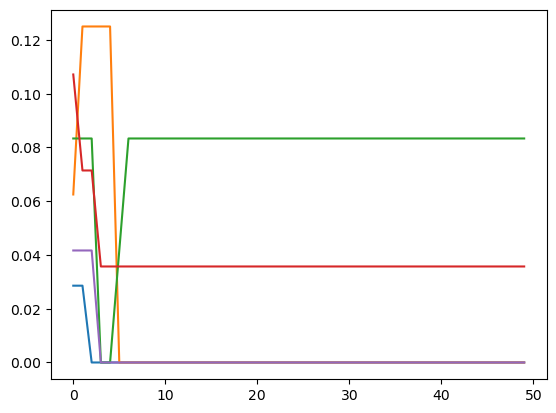

In [38]:
plt.plot(test_accuracies2)

In [39]:
print(losses2)

[[4.170898914337158, 4.278110027313232, 4.193741321563721, 4.131402254104614, 4.144367456436157], [4.087114016215007, 4.085063457489014, 4.040165543556213, 3.903476595878601, 3.9847549200057983], [4.064029852549235, 3.9947848320007324, 4.002399206161499, 3.8218436241149902, 3.9460673332214355], [4.270691871643066, 3.9424448013305664, 3.97058641910553, 3.7722182273864746, 3.949325919151306], [4.62914244333903, 3.906871199607849, 3.9466540813446045, 4.312154054641724, 3.973165988922119], [4.527706305185954, 3.9277831315994263, 3.929901599884033, 5.9154791831970215, 4.075879454612732], [5.678115526835124, 4.526081800460815, 3.961233615875244, 6.8316144943237305, 4.516364336013794], [6.51564359664917, 14.931541919708252, 4.197186231613159, 6.431580543518066, 16.252826690673828], [8.545275847117106, 24.24036693572998, 4.171975612640381, 7.32830548286438, 129.94551849365234], [11.288599967956543, 36.48317241668701, 5.8683905601501465, 6.123627662658691, 241.135498046875], [26.258175532023113

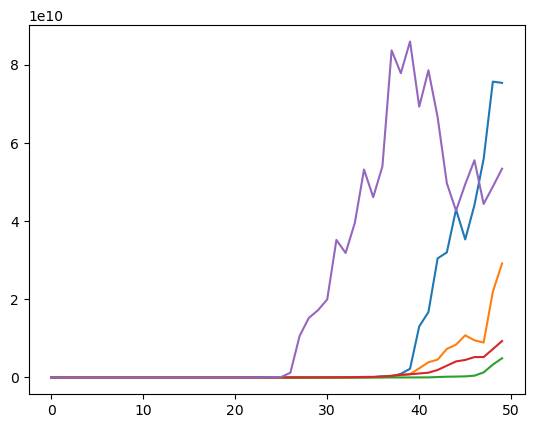

In [40]:
plt.plot(losses2)

In [41]:

nodes = []
for i in range(num_nodes):
    nodes.append(FederatedNode(train_loaders[i], test_loaders[i], i)) 


Dataset size  309
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  136
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  213
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  249
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  215
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])


In [42]:
with open(pickle_name+'.pickle', 'wb') as handle:
    pickle.dump(my_pickle_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
labels = []
for _, label in train_loaders[0]:
    labels.append(label)
#print(labels)
#print(classification_report(y_true, y_pred, target_names=target_names))

In [44]:
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2023-05-13 01:42:43


: 